In [1]:
# from LDPC_decoder import Decoder
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os    
import math
import galois
import itertools
import random
import pickle
import time

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [2]:
import pickle

def load_value_function(filename="MI_policy_0.pkl"):
    with open(filename, "rb") as f:
        Q = pickle.load(f)
    print(f"Q-function loaded from {filename}")
    return Q

def save_value_function(V, filename="value_function.pkl"):
    with open(filename, "wb") as f:
        pickle.dump(V, f)
    print(f"Value function saved to {filename}")


In [3]:
class Decoder:
    
    def __init__ (self,H, num_iter,cluster_size):
        # code parameters
        self.n = H.shape[1]
        self.k = self.n - H.shape[0]
        self.H = H
        self.num_iter = num_iter
        
        # misc parameters (epsilon : for numerical stability)
        self.ep = 1e-5
        
        # graph parameters
        self.num_VN = self.n
        self.num_CN = self.n-self.k
        self.cluster_size = cluster_size
        
        # adjacency list for VN and CN
        self.CN = []
        self.VN = []
        self.construct_graph(H)
        self.initialize_clusters(self.cluster_size)
        self.iteration_number = 0
        self.policy = None # policy for choosing clusters (using RL)
        self.llr_list = []
        self.scheduled_history = []
        self.pseudo_MI_gains_array = []
        self.sar_list = []
        
    # build the adjacency list for Tanner Graph
    def construct_graph(self,H):
        for i in range(self.num_CN):
            temp = []
            for j in range(self.num_VN):
                if H[i,j]==1:
                    temp.append(j)
            self.CN.append(temp)
            
        for i in range(self.num_VN):
            temp = []
            for j in range(self.num_CN):
                if H[j,i]==1:
                    temp.append(j)
            self.VN.append(temp)
    
    # print the tanner graph
    def print_graph(self,mode):
        if mode=="matrix":
            print(self.H)
        elif mode=="list":
            print('CN : ',self.CN)
            print('VN : ',self.VN)
        else:
            print('Invalid mode')
    
    
    # initialize clusters of CNs
    def initialize_clusters(self,cluster_size):
        self.num_clusters = math.ceil(self.num_CN/cluster_size)
        self.MI = np.zeros(self.num_clusters) # for storing current MI of clusters


        self.clusters = []
        for i in np.arange(0,self.num_CN,cluster_size):
            temp = []
            for j in range(i,min(i+cluster_size,self.num_CN)):
                temp.append(j)
            self.clusters.append(temp)  
            

                    
    # returns the absolute min, 2nd min and parity of the input array
    def get_min(self,arr):
        arr = np.array(arr)
        arr = arr[~np.isnan(arr)]
        parity = np.prod(np.sign(arr))
        if len(arr) < 2:
            print("arr = ",arr)
            raise ValueError("Not enough valid elements in the array.")
        arr = np.sort(np.abs(arr))
        return arr[0],arr[1],parity
    
    # perform row update of cluster a 
    def row_update(self,a):
        # subtract step (removing known beliefs)
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] - tot

        # flow down the sum into the cluster a
        for j in range(self.num_VN):
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = self.sum[j]

        # perform minsum for each row
        for i in self.clusters[a]:
            m1,m2,p = self.get_min(self.L[i])
            for j in range(self.num_VN):
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = p*np.sign(self.L[i,j])*m2 if np.abs(self.L[i,j])==m1 else p*np.sign(self.L[i,j])*m1

    def col_update(self,a):
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] + tot
        self.llr_list.append(self.sum.copy())
        # print("appending ",self.sum)

            
    def pseudo_row_update(self,a):
        # subtract step (removing known beliefs)
        p_L = self.L.copy()
        p_sum = self.sum.copy()
        
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    tot = tot + p_L[i,j]
            p_sum[j] = p_sum[j] - tot

        # flow down the sum into the cluster a
        for j in range(self.num_VN):
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    p_L[i,j] = p_sum[j]

        # perform minsum for each row
        for i in self.clusters[a]:
            m1,m2,p = self.get_min(p_L[i])
            for j in range(self.num_VN):
                if not np.isnan(p_L[i,j]):
                    p_L[i,j] = p*np.sign(p_L[i,j])*m2 if np.abs(p_L[i,j])==m1 else p*np.sign(p_L[i,j])*m1
        
        return p_L, p_sum

    def pseudo_col_update(self, a, p_L, p_sum):
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    tot = tot + p_L[i,j]
            p_sum[j] = p_sum[j] + tot
        
        return p_L


    def decode(self,y,verbose="off",scheduling="round-robin", state_definition="mi", exploring_starts=False, epsilon=None ):
        # sum is initialized by incoming beliefs (initial LLRs)
        self.sum = y
        
        # initializing the storage matrix
        self.L = np.full(self.H.shape, np.nan, dtype=float)  # Initialize with NaNs
        for i in range(self.num_CN):
            for j in range(self.num_VN):
                self.L[i,j] = 0 if self.H[i,j]==1 else np.nan
        
#         # initial MI approximation
#         self.MI = self.get_MI(self.L)
        state = None
        self.MI_list = []
        for k in range(self.num_iter):
            self.MI = self.get_MI(self.L)
            if verbose=="on":
                print("Mutual Info : ",self.MI)
            self.MI_list.append(self.MI)
            y_hat = np.array([1 if val<0 else 0 for val in self.sum])
            
            # getting state
            if state_definition=="mi":
                state = self.MI
            elif state_definition=="pseudo-difference":
                state = np.zeros(self.num_clusters)
                for a in range(self.num_clusters):
                    p_L, p_sum = self.pseudo_row_update(a)

                    MI_new = self.get_MI(p_L)
                    gain = MI_new - self.MI
                    state[a] = gain[a]

            disc_state = quantize(state, BINS)

            # error = np.sum((c+y_hat)%2)/len(y_hat)
            # error_list.append(error)
            # choosing action according to exploring starts
            a = None
            self.iteration_number = k
            if exploring_starts==True and k==0:
                if epsilon==None:
                    a = random.randrange(self.num_clusters)
                else:
                    if random.random() < epsilon:
                        a = self.get_next_cluster(k,scheduling)
                    else:
                        a = random.randrange(self.num_clusters)
            else:
                a = self.get_next_cluster(k,scheduling)
                
            action = a
            self.scheduled_history.append(a)
            if verbose=="on":
                print("Iteration : ",k,"\tCluster scheduled : ",a)
            self.row_update(a)
            self.col_update(a)

            # getting next state
            next_state = np.zeros(self.num_clusters)
            if state_definition=="mi":
                next_state = self.get_MI(self.L)
            elif state_definition=="pseudo-difference":
                # next_state = np.zeros(self.num_clusters)
                for a in range(self.num_clusters):
                    p_L, p_sum = self.pseudo_row_update(a)
                    MI_new = self.get_MI(p_L)
                    gain = MI_new - self.MI
                    next_state[a] = gain[a]
            disc_next_state = quantize(next_state, BINS)


            # getting reward
            reward = get_reward(None, state, action, next_state)

            sar = [disc_state, action, reward]
            self.sar_list.append(sar)

            c_hat = np.array([1 if val<0 else 0 for val in self.sum])
            if self.stopping_criteria(k,c_hat):
                if verbose=="on":
                    print("Mutual Info : ",self.get_MI(self.L))
                self.MI_list.append(self.get_MI(self.L))
                y_hat = np.array([1 if val<0 else 0 for val in self.sum])
                # error = np.sum((c+y_hat)%2)/len(y_hat)
                # error_list.append(error)
                break
        return c_hat, self.sar_list
    
    def get_MI(self,L):
        var = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            total = 0
            count = 0
            for i in self.clusters[a]:
                for j in self.CN[i]:
                    total = total + np.abs(L[i,j])
                    count = count + 1
            mean = total/count
            var[a] = mean*2
        
        MI = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            MI[a] = self.J(var[a])
        
        return MI

        
    def J(self,sigma):
        # constants
        a_J1 = -0.0421061
        b_J1 = 0.209252
        c_J1 = -0.00640081

        a_J2 = 0.00181491
        b_J2 = -0.142675
        c_J2 = -0.0822054
        d_J2 = 0.0549608

        # threshold sigma*
        sigma_star = 1.6363
        
        if 0 <= sigma <= sigma_star:
            return a_J1 * sigma**3 + b_J1 * sigma**2 + c_J1 * sigma
        elif sigma_star < sigma < 10:
            exponent = a_J2 * sigma**3 + b_J2 * sigma**2 + c_J2 * sigma + d_J2
            return 1 - math.exp(exponent)
        else:  # sigma >= 10
            return 1

            
        
    def stopping_criteria(self,k,c_hat):
        # if k>40:
        #     return True
        # else:
        #     return False
        c1 = k>self.num_iter
        c2 = (np.sum(np.dot(self.H,c_hat.T)%2)==0)
        return c1 or c2
    
    # calculates the difference between information metrics for cluster a
    def calculate_residual(self, info, info_new, a):
        return info_new[a] - info[a]
    
    def get_next_cluster(self,iter_number,scheduling):
        # round robin
        if scheduling=="round-robin":
            return (iter_number%self.num_clusters)
        
        elif scheduling=="residual-llr":
            llr_gains = np.zeros(self.num_clusters)
            for a in range(self.num_clusters):
                p_L, p_sum = self.pseudo_row_update(a)
                max_diff = -100000
                for j in self.CN[a]:
                    max_diff = max(np.abs(self.L[a,j]-p_L[a,j]),max_diff)
                llr_gains[a] = max_diff
            return np.argmax(llr_gains)
                
    
        # Information Gain
        MI_gains = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            p_L, p_sum = self.pseudo_row_update(a)
            p_L = self.pseudo_col_update(a,p_L,p_sum)
            MI_new = self.get_MI(p_L)
            gain = self.calculate_residual(self.MI, MI_new, a)
            MI_gains[a] = gain
        
        self.pseudo_MI_gains_array.append(MI_gains)            
        a = np.argmax(MI_gains)
        return a
        

In [4]:
def circular_shift_identity(z, k):
    if k == -1:
        return np.zeros((z, z), dtype=int)
    else:
        return np.roll(np.eye(z, dtype=int), -k, axis=1)

def expand_base_matrix(B, z):
    m, n = B.shape
    H = np.zeros((m * z, n * z), dtype=int)  # Full parity check matrix initialized to zeros

    for i in range(m):
        for j in range(n):
            # Expand each base matrix element into a z x z block
            block = circular_shift_identity(z, B[i, j])
            H[i * z:(i + 1) * z, j * z:(j + 1) * z] = block

    return H

def get_codewords(H):
    GF = galois.GF(2)
    A = GF(H)
    N = A.null_space()
    vec = [np.array(v) for v in itertools.product([0, 1], repeat=N.shape[0])]
    C = np.array(GF(vec) @ N)
    return C


def save_q_table(q_table, filename="q_table.pkl"):
    """
    Save Q-table to a file using pickle.
    """
    with open(filename, "wb") as f:
        pickle.dump(dict(q_table), f)  # Convert defaultdict to dict before saving

def quantize(s, bins):
    """
    Discretizes a continuous state vector into bins.
    
    Args:
        s (np.ndarray): Continuous state vector with values between -1 and 1
        bins (int): Number of discrete bins per dimension
    
    Returns:
        tuple: Discretized state indices as a tuple
    """
    clamped = np.clip(s, -1, 1)
    indices = []
    bin_width = 2 / bins
    for value in clamped:
        index = int((value + 1) / bin_width)
        index = min(index, bins - 1)  # Ensure we stay within bounds
        indices.append(index)
    return tuple(indices)


def dequantize(disc_s, bins):
    """
    Converts a discretized state back to continuous space (midpoint of bins).
    
    Args:
        disc_s (tuple): Discretized state indices
        bins (int): Number of discrete bins per dimension used in quantization
    
    Returns:
        np.ndarray: Continuous state vector approximation
    """
    continuous = []
    bin_width = 2 / bins
    for index in disc_s:
        midpoint = -1 + (index + 0.5) * bin_width
        continuous.append(midpoint)
    return np.array(continuous)



In [5]:

# B = np.array([
#     [0, 1, -1, -1, -1, -1, -1, -1, -1, -1],
#     [-1, 0, 1, -1, -1, -1, -1, -1, -1, -1],
#     [1, -1, 2, -1, 3, -1, 4, -1, 5, -1],
#     [-1, 2, -1, 3, -1, 4, -1, 5, -1, 0],
#     [3, -1, 4, -1, 5, -1, 0, -1, 1, -1],
#     [-1, 4, -1, 5, -1, 0, -1, 1, -1, 2],
#     [5, -1, 0, -1, 1, -1, 2, -1, 3, -1],
#     [-1, 0, -1, 1, -1, 2, -1, 3, -1, 4]
# ])

# print("B = \n",B)
# z = 5

# H = expand_base_matrix(B,z)
# np.savetxt('output.txt',H,fmt="%d")
# print("H : \n",H)

# C = get_codewords(H)
# print("Codewords : \n",C)
# print(len(C)," codewords found")
# dmin = np.min(np.sum(C[1:],axis=1))
# print("dmin = ",dmin)

# print("Shape of H : ",H.shape)


# B = np.array([[0,2,-1,3,-1,-1,2,4,1,0],
#             [3,1,-1,-1,0,0,1,2,3,0],
#             [1,0,0,-1,1,4,2,1,0,-1],
#             [-1,0,0,2,3,-1,-1,-1,0,-1],
#             [1,0,2,0,1,0,-1,-1,-1,-1],
#             [2,1,0,0,2,-1,-1,-1,1,-1]]
#             ,dtype=int)

B = np.array([  [0, 2, -1, 3, 0, 0,-1, -1, -1, -1],
                [3, 1, -1,-1, 1, 0, 0, -1, -1, -1],
                [1, -1, 2, -1, 0,-1, 0, -1, -1, -1],
                [-1, 1, -1, 2, 3, -1,-1,  0, -1, -1],
                [2, -1, 2, 0, -1,  0,-1, -1,  0, -1],
                [1, -1, 4, 0, 2, -1, 3, -1, -1,  0]]
                ,dtype=int)

# B = np.array([[-1,0,1],
#              [1,0,2]],dtype=int)
print("B = \n",B)
z = 5

H = expand_base_matrix(B,z)
np.savetxt('output.txt',H,fmt="%d")
print("H : \n",H)

C = get_codewords(H)
print("Codewords : \n",C)
print(len(C)," codewords found")
dmin = np.min(np.sum(C[1:],axis=1))
print("dmin = ",dmin)
print("shape of H : ",H.shape)


B = 
 [[ 0  2 -1  3  0  0 -1 -1 -1 -1]
 [ 3  1 -1 -1  1  0  0 -1 -1 -1]
 [ 1 -1  2 -1  0 -1  0 -1 -1 -1]
 [-1  1 -1  2  3 -1 -1  0 -1 -1]
 [ 2 -1  2  0 -1  0 -1 -1  0 -1]
 [ 1 -1  4  0  2 -1  3 -1 -1  0]]
H : 
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 0]
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
Codewords : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 1]]
1048576  codewords found
dmin =  7
shape of H :  (30, 50)


In [6]:
B = np.array([[0,2,-1,3,-1,-1,2,4,1,0],
            [3,1,-1,-1,0,0,1,2,3,0],
            [1,0,0,-1,1,4,2,1,0,-1],
            [-1,0,0,2,3,-1,-1,-1,0,-1],
            [1,0,2,0,1,0,-1,-1,-1,-1],
            [2,1,0,0,2,-1,-1,-1,1,-1]]
            ,dtype=int)

# B = np.array([[-1,0,1],
#              [1,0,2]],dtype=int)
print("B = \n",B)
z = 5

H = expand_base_matrix(B,z)
np.savetxt('output.txt',H,fmt="%d")
print("H : \n",H.shape)

C = get_codewords(H)
print("Codewords : \n",C)
print(len(C)," codewords found")
dmin = np.min(np.sum(C[1:],axis=1))
print("dmin = ",dmin)

B = 
 [[ 0  2 -1  3 -1 -1  2  4  1  0]
 [ 3  1 -1 -1  0  0  1  2  3  0]
 [ 1  0  0 -1  1  4  2  1  0 -1]
 [-1  0  0  2  3 -1 -1 -1  0 -1]
 [ 1  0  2  0  1  0 -1 -1 -1 -1]
 [ 2  1  0  0  2 -1 -1 -1  1 -1]]
H : 
 (30, 50)
Codewords : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
1048576  codewords found
dmin =  9


In [8]:
def initialize_ldpc_decoder(H, snrdb, c, num_iter, cluster_size):
    snr = math.pow(10,snrdb/20)
    sigma = 1/math.sqrt(snr)
    y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape)

    dec = Decoder(H,num_iter,cluster_size)
    dec.sum = y
    dec.L = np.full(dec.H.shape, np.nan, dtype=float)
    for i in range(dec.num_CN):
        for j in range(dec.num_VN):
            dec.L[i,j] = 0 if dec.H[i,j]==1 else np.nan
    dec.MI = dec.get_MI(dec.L)

    return dec

def get_state(dec, state_definition):
    dec.MI = dec.get_MI(dec.L)
    if state_definition=="pseudo-difference":
        MI_gains = np.zeros(dec.num_clusters)
        for a in range(dec.num_clusters):
            p_L, p_sum = dec.pseudo_row_update(a)
            MI_new = dec.get_MI(p_L)
            gain = MI_new[a] - dec.MI[a]
            MI_gains[a] = gain
        return MI_gains
    elif state_definition=="MI":
        state = np.zeros(dec.num_clusters)
        state = dec.MI
        return state  
def get_reward(dec, state, action, next_state):
    reward = next_state[action]
    return reward


def generate_episode():
    if verbose1=="on":
        print("Generating Episode...\n")
    c = C[np.random.choice(len(C))] # correct codeword
    snr = math.pow(10,snrdb_value/20)
    sigma = 1/math.sqrt(snr)
    y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape) # noisy codeword
    c_sent = np.array([1 if val<0 else 0 for val in y])
    dec = initialize_ldpc_decoder(H=H, snrdb=snrdb_value, c=c, num_iter=num_iter, cluster_size=cluster_size)
    
    # initial state is the same for all episodes
    state = get_state(dec, state_definition)

    decoded_codeword, episode_list = dec.decode(y,verbose=verbose1,scheduling="mi",state_definition=state_definition)

    # for ep in episode_list:
    #     s,a,r = ep
    #     print("action = ",a,"\treward = ",r)
    if verbose2=="on":
        print(f"{len(episode_list)} length episode generated!")
        print(f"Error : {(np.sum(decoded_codeword+c)%2)}/{len(c)}")
        # print(f"c = {c}\nd = {decoded_codeword}")
    return episode_list


### First Visit Monte Carlo Policy Evaluation

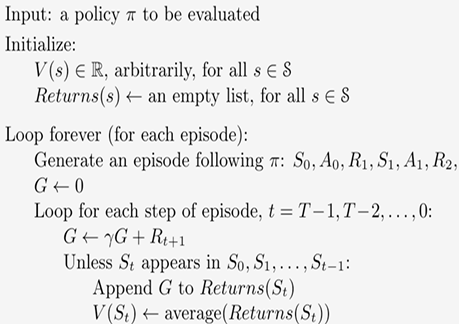

## V(s) evaluation : First Visit

In [147]:
def first_visit_mc_policy_evaluation(generate_episode, state_dim, bins, gamma=0.99, num_episodes=10000):

    V = defaultdict(float)
    returns = defaultdict(list)
    
    for iter_num in range(num_episodes):
        t1 = time.time()
        episode = generate_episode()
        t2 = time.time()

        print(f"Iter num : {iter_num}\tEpisode Length : {len(episode)}\t Time : {t2-t1:.2f} sec")
        G = 0
        visited_states = set()
        episode_length = len(episode)
        
        # Reverse loop to calculate returns
        for t in reversed(range(episode_length)):
            S_t, A_t, R_t_plus_1 = episode[t][0], episode[t][1], episode[t][2]
            G = gamma * G + R_t_plus_1  # Compute return
            
            # First-visit check
            if S_t not in visited_states:
                visited_states.add(S_t)
                returns[S_t].append(G)
                V[S_t] = np.mean(returns[S_t])  # Update value function
    
    return V


In [155]:
num_iter=150
cluster_size=15
snrdb_value = 0.7
scheduling = "mi"
state_definition="pseudo-difference"
STATE_DIM = math.ceil(H.shape[0]/cluster_size)
BINS = 40
verbose1 = "off"
verbose2 = "off"

V = first_visit_mc_policy_evaluation(
    generate_episode=generate_episode,
    state_dim=STATE_DIM,
    bins=BINS,
    gamma=0.9,
    num_episodes=10
    )

# print(V)

Iter num : 0	Episode Length : 150	 Time : 2.57 sec
Iter num : 1	Episode Length : 150	 Time : 2.37 sec
Iter num : 2	Episode Length : 150	 Time : 2.34 sec
Iter num : 3	Episode Length : 150	 Time : 2.33 sec
Iter num : 4	Episode Length : 150	 Time : 2.23 sec
Iter num : 5	Episode Length : 150	 Time : 2.22 sec
Iter num : 6	Episode Length : 150	 Time : 2.18 sec
Iter num : 7	Episode Length : 150	 Time : 2.18 sec
Iter num : 8	Episode Length : 150	 Time : 2.32 sec
Iter num : 9	Episode Length : 150	 Time : 2.39 sec


In [156]:
for k in range(100):
    s = np.random.uniform(0,0.4,STATE_DIM)
    s_d = quantize(s,BINS)
    val = V.get(s_d,-1e10)
    print(f"State : {s}\t d_s : {s_d}\t Value : {val}")

State : [0.01821193 0.12520511]	 d_s : (20, 22)	 Value : -10000000000.0
State : [0.25129751 0.13422162]	 d_s : (25, 22)	 Value : -10000000000.0
State : [0.33263035 0.25143276]	 d_s : (26, 25)	 Value : -10000000000.0
State : [0.1229331  0.20864738]	 d_s : (22, 24)	 Value : -10000000000.0
State : [0.1104848  0.18751231]	 d_s : (22, 23)	 Value : -10000000000.0
State : [0.24956552 0.14094559]	 d_s : (24, 22)	 Value : -10000000000.0
State : [0.29370281 0.00645641]	 d_s : (25, 20)	 Value : 0.02005966782834856
State : [0.15306736 0.30251076]	 d_s : (23, 26)	 Value : 0.4839947145508761
State : [0.31894971 0.32554442]	 d_s : (26, 26)	 Value : -10000000000.0
State : [0.07462663 0.34723383]	 d_s : (21, 26)	 Value : -10000000000.0
State : [0.38708097 0.17502222]	 d_s : (27, 23)	 Value : -10000000000.0
State : [0.12872595 0.2516965 ]	 d_s : (22, 25)	 Value : -10000000000.0
State : [0.18713711 0.04309679]	 d_s : (23, 20)	 Value : -10000000000.0
State : [0.17373891 0.0509096 ]	 d_s : (23, 21)	 Value 

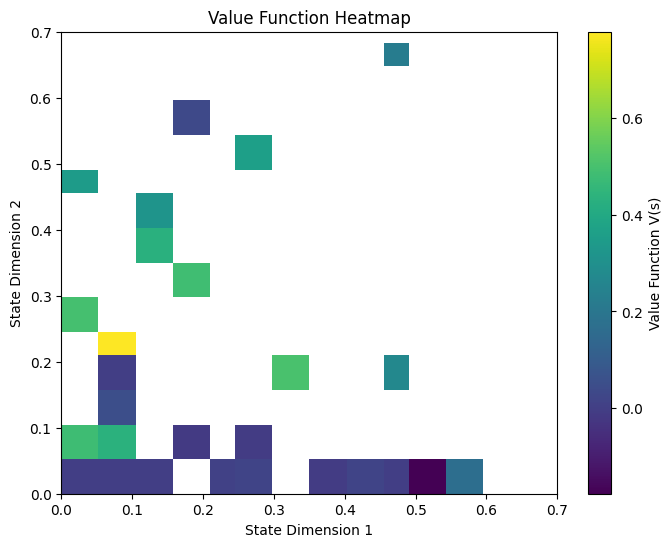

In [158]:
state_range=(0, 0.7)
# Create a grid of state values
x = np.linspace(state_range[0], state_range[1], BINS)
y = np.linspace(state_range[0], state_range[1], BINS)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)
v_min=-1e7
v_max=1e7

# Compute V(s) for each (x, y) pair
for i in range(BINS):
    for j in range(BINS):
        s = np.array([X[i, j], Y[i, j]])  # Continuous state
        s_d = quantize(s, BINS)  # Discretized state
        value = V.get(s_d, np.nan)  # Use NaN for unseen states

        # Ignore extreme values
        if value < v_min or value > v_max:
            Z[i, j] = np.nan  # Mask extreme values
        else:
            Z[i, j] = value

# Plot heatmap, ignoring NaNs
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=[state_range[0], state_range[1], state_range[0], state_range[1]],
            origin="lower", cmap="viridis", aspect="auto", interpolation="nearest")
plt.colorbar(label="Value Function V(s)")
plt.xlabel("State Dimension 1")
plt.ylabel("State Dimension 2")
plt.title("Value Function Heatmap")
plt.show()  

## Q(s,a) evaluation : First Visit

In [ ]:
def first_visit_mc_q_evaluation(generate_episode, gamma=0.99, num_episodes=10000):

    Q = defaultdict(float)
    returns = defaultdict(list)

    for iter_num in range(num_episodes):
        t1 = time.time()
        episode = generate_episode()
        t2 = time.time()
        print(f"Iter num : {iter_num}\tEpisode Length : {len(episode)}\t Time : {t2-t1:.2f} sec")

        G = 0
        visited_state_actions = set()
        episode_length = len(episode)

        # Reverse loop to calculate returns
        for t in reversed(range(episode_length)):
            S_t, A_t, R_t_plus_1 = episode[t]
            G = gamma * G + R_t_plus_1  # Compute return
            
            # First-visit check for (S_t, A_t)
            if (S_t, A_t) not in visited_state_actions:
                visited_state_actions.add((S_t, A_t))
                returns[(S_t, A_t)].append(G)
                Q[(S_t, A_t)] = np.mean(returns[(S_t, A_t)])  # Update Q-value

    return Q


In [ ]:
num_iter=150
cluster_size=6
snrdb_value = 1.5
scheduling = "mi"
state_definition="pseudo-difference"
STATE_DIM = math.ceil(H.shape[0]/cluster_size)
BINS = 10
verbose1 = "off"
verbose2 = "off"


Q = first_visit_mc_q_evaluation(
    generate_episode=generate_episode,
    gamma=0.9,
    num_episodes=2000
    )

Iter num : 0	Episode Length : 4	 Time : 0.03 sec
Iter num : 1	Episode Length : 5	 Time : 0.05 sec
Iter num : 2	Episode Length : 8	 Time : 0.05 sec
Iter num : 3	Episode Length : 2	 Time : 0.02 sec
Iter num : 4	Episode Length : 58	 Time : 0.43 sec
Iter num : 5	Episode Length : 116	 Time : 0.75 sec
Iter num : 6	Episode Length : 5	 Time : 0.04 sec
Iter num : 7	Episode Length : 2	 Time : 0.01 sec
Iter num : 8	Episode Length : 3	 Time : 0.02 sec
Iter num : 9	Episode Length : 2	 Time : 0.02 sec
Iter num : 10	Episode Length : 150	 Time : 0.98 sec
Iter num : 11	Episode Length : 70	 Time : 0.48 sec
Iter num : 12	Episode Length : 150	 Time : 0.96 sec
Iter num : 13	Episode Length : 150	 Time : 0.95 sec
Iter num : 14	Episode Length : 5	 Time : 0.03 sec
Iter num : 15	Episode Length : 150	 Time : 0.99 sec
Iter num : 16	Episode Length : 150	 Time : 1.35 sec
Iter num : 17	Episode Length : 9	 Time : 0.06 sec
Iter num : 18	Episode Length : 150	 Time : 1.07 sec
Iter num : 19	Episode Length : 83	 Time : 0.

In [196]:
for k in range(10):
    s = np.random.rand(STATE_DIM)
    s_d = quantize(s,BINS)
    a = 0
    val = Q.get((s_d,a),-1e10)
    print(f"State : {s,a}\t d_s : {s_d,a}\t Value : {val}")

State : (array([0.66903475, 0.40328371, 0.88900648, 0.57420866, 0.26862321]), 0)	 d_s : ((6, 3, 8, 5, 2), 0)	 Value : -10000000000.0
State : (array([0.02146391, 0.997482  , 0.97718894, 0.28805547, 0.06866438]), 0)	 d_s : ((0, 8, 8, 2, 0), 0)	 Value : -10000000000.0
State : (array([0.93429495, 0.34957349, 0.56252548, 0.30522379, 0.68213676]), 0)	 d_s : ((8, 3, 5, 2, 6), 0)	 Value : -10000000000.0
State : (array([0.79628897, 0.14017709, 0.38510647, 0.28551662, 0.54290695]), 0)	 d_s : ((7, 1, 3, 2, 4), 0)	 Value : -10000000000.0
State : (array([0.74758729, 0.04813976, 0.80160961, 0.91156554, 0.21230018]), 0)	 d_s : ((6, 0, 7, 8, 1), 0)	 Value : -10000000000.0
State : (array([0.80612228, 0.00099544, 0.39678399, 0.92301557, 0.59896348]), 0)	 d_s : ((7, 0, 3, 8, 5), 0)	 Value : -10000000000.0
State : (array([0.88952351, 0.2507533 , 0.72463599, 0.59296449, 0.34795846]), 0)	 d_s : ((8, 2, 6, 5, 3), 0)	 Value : -10000000000.0
State : (array([0.80706989, 0.35771533, 0.74387848, 0.30209833, 0.694

# Every-Visit MC Policy Evaluation

## V(s) evaluation : Every Visit

In [154]:
def every_visit_mc_v_evaluation(generate_episode, gamma=0.99, num_episodes=10000):

    V = defaultdict(float)
    returns = defaultdict(list)

    for iter_num in range(num_episodes):
        t1 = time.time()
        episode = generate_episode()
        t2 = time.time()
        print(f"Iter num : {iter_num}\tEpisode Length : {len(episode)}\t Time : {t2-t1:.2f} sec")

        G = 0
        episode_length = len(episode)

        # Reverse loop to calculate returns
        for t in reversed(range(episode_length)):
            S_t, _, R_t_plus_1 = episode[t]  # Ignore actions since we're computing V(s)
            G = gamma * G + R_t_plus_1  # Compute return

            # Every-visit MC updates every occurrence of S_t
            returns[S_t].append(G)
            V[S_t] = np.mean(returns[S_t])  # Update V(s)

    return V


In [ ]:
num_iter=150
cluster_size=15
snrdb_value = 1.5
scheduling = "mi"
state_definition="pseudo-difference"
STATE_DIM = math.ceil(H.shape[0]/cluster_size)
BINS = 10
verbose1 = "off"
verbose2 = "off"

V_every_visit = every_visit_mc_v_evaluation(
    generate_episode=generate_episode,
    gamma=0,
    num_episodes=100
    )


Iter num : 0	Episode Length : 2	 Time : 0.03 sec
Iter num : 1	Episode Length : 150	 Time : 1.28 sec
Iter num : 2	Episode Length : 150	 Time : 1.27 sec
Iter num : 3	Episode Length : 150	 Time : 1.21 sec
Iter num : 4	Episode Length : 6	 Time : 0.05 sec
Iter num : 5	Episode Length : 150	 Time : 1.25 sec
Iter num : 6	Episode Length : 150	 Time : 1.13 sec
Iter num : 7	Episode Length : 150	 Time : 1.26 sec
Iter num : 8	Episode Length : 150	 Time : 1.16 sec
Iter num : 9	Episode Length : 150	 Time : 1.14 sec
Iter num : 10	Episode Length : 150	 Time : 1.22 sec
Iter num : 11	Episode Length : 150	 Time : 1.18 sec
Iter num : 12	Episode Length : 150	 Time : 1.19 sec
Iter num : 13	Episode Length : 150	 Time : 1.19 sec
Iter num : 14	Episode Length : 150	 Time : 1.13 sec
Iter num : 15	Episode Length : 4	 Time : 0.03 sec
Iter num : 16	Episode Length : 150	 Time : 1.18 sec
Iter num : 17	Episode Length : 150	 Time : 1.28 sec
Iter num : 18	Episode Length : 150	 Time : 1.18 sec
Iter num : 19	Episode Length

In [247]:
for k in range(100):
    s = np.random.uniform(0,0.4,STATE_DIM)
    s_d = quantize(s,BINS)
    val = V_every_visit.get(s_d,-1e10)
    print(f"State : {s}\t d_s : {s_d}\t Value : {val}")

State : [0.11754386 0.27982689]	 d_s : (1, 2)	 Value : 0.0055188788975952694
State : [0.11159655 0.24879045]	 d_s : (1, 2)	 Value : 0.0055188788975952694
State : [0.07698195 0.02388759]	 d_s : (0, 0)	 Value : 0.013998086830312315
State : [0.12521008 0.24983022]	 d_s : (1, 2)	 Value : 0.0055188788975952694
State : [0.08260399 0.19631956]	 d_s : (0, 1)	 Value : 0.012478648237792498
State : [0.02164487 0.11067265]	 d_s : (0, 0)	 Value : 0.013998086830312315
State : [0.29375919 0.10225282]	 d_s : (2, 0)	 Value : 0.004974833934568344
State : [0.13035517 0.19982107]	 d_s : (1, 1)	 Value : 0.013890899538378413
State : [0.1254248  0.01951078]	 d_s : (1, 0)	 Value : 0.06660489434469563
State : [0.05410733 0.36868229]	 d_s : (0, 3)	 Value : 0.03427726264998448
State : [0.02003739 0.11599715]	 d_s : (0, 1)	 Value : 0.012478648237792498
State : [0.35295399 0.39517503]	 d_s : (3, 3)	 Value : -10000000000.0
State : [0.2187255  0.36871412]	 d_s : (1, 3)	 Value : -0.0032625686730403222
State : [0.0039

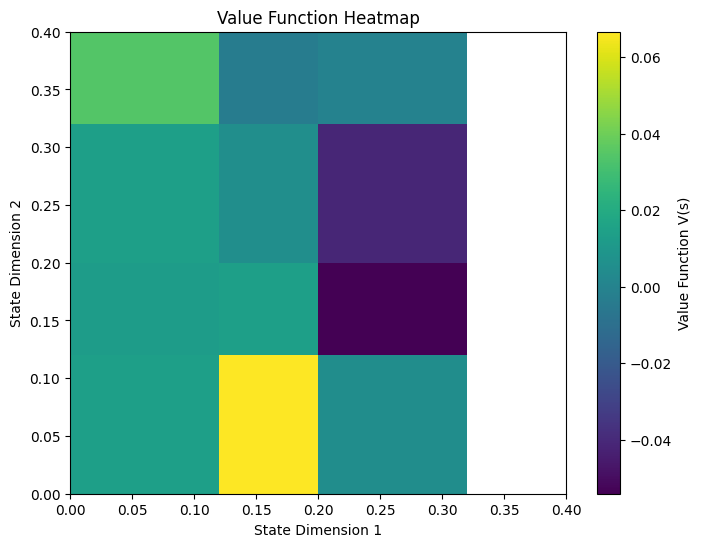

In [249]:
state_range=(0, 0.4)
# Create a grid of state values
x = np.linspace(state_range[0], state_range[1], BINS)
y = np.linspace(state_range[0], state_range[1], BINS)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)
v_min=-1e7
v_max=1e7

# Compute V(s) for each (x, y) pair
for i in range(BINS):
    for j in range(BINS):
        s = np.array([X[i, j], Y[i, j]])  # Continuous state
        s_d = quantize(s, BINS)  # Discretized state
        value = V_every_visit.get(s_d, np.nan)  # Use NaN for unseen states

        # Ignore extreme values
        if value < v_min or value > v_max:
            Z[i, j] = np.nan  # Mask extreme values
        else:
            Z[i, j] = value

# Plot heatmap, ignoring NaNs
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=[state_range[0], state_range[1], state_range[0], state_range[1]],
            origin="lower", cmap="viridis", aspect="auto", interpolation="nearest")
plt.colorbar(label="Value Function V(s)")
plt.xlabel("State Dimension 1")
plt.ylabel("State Dimension 2")
plt.title("Value Function Heatmap")
plt.show()

## Q(s,a) Evaluation : Every Visit

In [ ]:
def every_visit_mc_q_evaluation(generate_episode, gamma=0.99, num_episodes=10000):
    Q = defaultdict(float) 
    returns = defaultdict(list) 

    for iter_num in range(num_episodes):
        t1 = time.time()
        episode = generate_episode()
        t2 = time.time()
        print(f"Iter num : {iter_num}\tEpisode Length : {len(episode)}\t Time : {t2-t1:.2f} sec")
        
        G = 0
        episode_length = len(episode)

        # Reverse loop to calculate returns
        for t in reversed(range(episode_length)):
            S_t, A_t, R_t_plus_1 = episode[t]
            G = gamma * G + R_t_plus_1  # Compute return

            # Every-visit MC updates every occurrence of (S_t, A_t)
            returns[(S_t, A_t)].append(G)
            Q[(S_t, A_t)] = np.mean(returns[(S_t, A_t)])  # Update Q-value

    return Q


In [ ]:
num_iter=150
cluster_size=6
snrdb_value = 1.5
scheduling = "mi"
state_definition="pseudo-difference"
STATE_DIM = math.ceil(H.shape[0]/cluster_size)
BINS = 10
verbose1 = "off"
verbose2 = "off"


Q_every_visit = every_visit_mc_q_evaluation(
    generate_episode=generate_episode,
    gamma=0.9,
    num_episodes=100
    )

Iter num : 0	Episode Length : 2	 Time : 0.02 sec
Iter num : 1	Episode Length : 74	 Time : 0.67 sec
Iter num : 2	Episode Length : 35	 Time : 0.32 sec
Iter num : 3	Episode Length : 4	 Time : 0.05 sec
Iter num : 4	Episode Length : 150	 Time : 1.49 sec
Iter num : 5	Episode Length : 10	 Time : 0.07 sec
Iter num : 6	Episode Length : 2	 Time : 0.02 sec
Iter num : 7	Episode Length : 150	 Time : 1.24 sec
Iter num : 8	Episode Length : 50	 Time : 0.52 sec
Iter num : 9	Episode Length : 3	 Time : 0.02 sec
Iter num : 10	Episode Length : 134	 Time : 1.11 sec
Iter num : 11	Episode Length : 150	 Time : 1.23 sec
Iter num : 12	Episode Length : 6	 Time : 0.05 sec
Iter num : 13	Episode Length : 33	 Time : 0.27 sec
Iter num : 14	Episode Length : 150	 Time : 1.08 sec
Iter num : 15	Episode Length : 1	 Time : 0.02 sec
Iter num : 16	Episode Length : 150	 Time : 1.15 sec
Iter num : 17	Episode Length : 37	 Time : 0.29 sec
Iter num : 18	Episode Length : 150	 Time : 1.13 sec
Iter num : 19	Episode Length : 4	 Time :

In [197]:
for k in range(10):
    s = np.random.rand(STATE_DIM)
    s_d = quantize(s,BINS)
    a = 0
    val = Q_every_visit.get((s_d,a),-1e10)
    print(f"State : {s,a}\t d_s : {s_d,a}\t Value : {val}")

State : (array([0.1717113 , 0.05527839, 0.5800374 , 0.90810659, 0.77833352]), 0)	 d_s : ((1, 0, 5, 8, 7), 0)	 Value : -10000000000.0
State : (array([0.68800983, 0.14605326, 0.84373463, 0.38821533, 0.28123698]), 0)	 d_s : ((6, 1, 7, 3, 2), 0)	 Value : -10000000000.0
State : (array([0.12062242, 0.19625043, 0.06597662, 0.87067563, 0.76869249]), 0)	 d_s : ((1, 1, 0, 7, 6), 0)	 Value : -10000000000.0
State : (array([0.83949466, 0.23495923, 0.06447392, 0.80909053, 0.77209845]), 0)	 d_s : ((7, 2, 0, 7, 6), 0)	 Value : -10000000000.0
State : (array([0.84372653, 0.15393893, 0.9616487 , 0.33752753, 0.55477352]), 0)	 d_s : ((7, 1, 8, 3, 4), 0)	 Value : -10000000000.0
State : (array([0.37053666, 0.02264918, 0.94567853, 0.19712003, 0.08008421]), 0)	 d_s : ((3, 0, 8, 1, 0), 0)	 Value : -10000000000.0
State : (array([0.45240001, 0.97889638, 0.70064484, 0.37015443, 0.04499718]), 0)	 d_s : ((4, 8, 6, 3, 0), 0)	 Value : -10000000000.0
State : (array([0.30060248, 0.24633037, 0.82213806, 0.3558442 , 0.944

## Initial State MC policy Evaluation

In [41]:
def initial_state_mc_policy_evaluation(generate_episode, num_episodes=1000, gamma=1.0):
    """
    Performs Initial-State Monte Carlo Policy Evaluation.
    
    Args:
        generate_episode: Function that returns an episode as (S0, A0, R1, ..., S_{T-1}, A_{T-1}, R_T).
        num_episodes: Number of episodes to sample.
        gamma: Discount factor.

    Returns:
        V: Estimated value function V(s) stored as a dictionary.
    """
    V = {}  # Value function
    N = {}  # State visit count

    for iter_num in range(1, num_episodes + 1):
        t1 = time.time()
        episode = generate_episode()
        t2 = time.time()
        print(f"Iter num : {iter_num}\tEpisode Length : {len(episode)}\t Time : {t2-t1:.2f} sec")
        rewards = []
        for e in episode:
            # print(e[2])
            rewards.append(e[2])
        # print(rewards)
        # break
        S_0 = episode[0][0]  # Initial state (quantized)
        # print(f"Starting state : {S_0}\tDeqiantized : {dequantize(S_0,BINS)}")
        # print(f"Episode = {episode}")
        # print(type(S_0))
        # break
        # rewards = episode[2::3]  # Extract all rewards

        # for r in rewards:
        #     print(type(r), r)
        # break
        # Compute return G_0 for the initial state
        G_0 = sum(r * (gamma ** i) for i, r in enumerate(rewards))

        # Update value function V(S_0)
        if S_0 not in V:
            V[S_0] = 0
            N[S_0] = 0
        # else:
        #     print("Encountered ",S_0," again")

        N[S_0] += 1
        alpha_k = 1 / N[S_0]  # Step size
        V[S_0] = V[S_0] + alpha_k * (G_0 - V[S_0])  # Update rule

    return V


In [9]:
def initial_state_mc_policy_evaluation_q(generate_episode, num_episodes=1000, gamma=1.0):
    """
    Performs Initial-State Monte Carlo Policy Evaluation.
    
    Args:
        generate_episode: Function that returns an episode as (S0, A0, R1, ..., S_{T-1}, A_{T-1}, R_T).
        num_episodes: Number of episodes to sample.
        gamma: Discount factor.

    Returns:
        V: Estimated value function V(s) stored as a dictionary.
    """
    V = defaultdict(float) 
    N = defaultdict(float) # state action visit count

    for iter_num in range(1, num_episodes + 1):
        t1 = time.time()
        episode = generate_episode()
        t2 = time.time()
        print(f"Iter num : {iter_num}\tEpisode Length : {len(episode)}\t Time : {t2-t1:.2f} sec")
        rewards = []
        for e in episode:
            # print(e[2])
            rewards.append(e[2])
        # print(rewards)
        # break
        S_0 = episode[0][0] # initial state
        A_0 = episode[0][1]  # initial action

        # print(f"Starting state : {S_0}\tDeqiantized : {dequantize(S_0,BINS)}")
        # print(f"Episode = {episode}")
        # print(type(S_0))
        # break
        # rewards = episode[2::3]  # Extract all rewards

        # for r in rewards:
        #     print(type(r), r)
        # break
        # Compute return G_0 for the initial state
        G_0 = sum(r * (gamma ** i) for i, r in enumerate(rewards))

        # Update value function V(S_0)
        if S_0 not in V:
            V[(S_0,A_0)] = 0
            N[(S_0,A_0)] = 0
        # else:
        #     print("Encountered ",S_0," again")

        N[(S_0,A_0)] += 1
        alpha_k = 1 / N[(S_0,A_0)]  # Step size
        V[(S_0,A_0)] = V[(S_0,A_0)] + alpha_k * (G_0 - V[(S_0,A_0)])  # Update rule

    return V


In [10]:
num_iter=150
cluster_size=15
snrdb_value = 1.5
scheduling = "mi"
state_definition="pseudo-difference"
STATE_DIM = math.ceil(H.shape[0]/cluster_size)
BINS = 100
verbose1 = "off"
verbose2 = "off"

V = initial_state_mc_policy_evaluation(
    generate_episode=generate_episode,
    gamma=0.9,
    num_episodes=6000
    )

# print(V)

Iter num : 1	Episode Length : 150	 Time : 2.36 sec
Iter num : 2	Episode Length : 150	 Time : 2.24 sec
Iter num : 3	Episode Length : 150	 Time : 2.28 sec
Iter num : 4	Episode Length : 150	 Time : 2.79 sec
Iter num : 5	Episode Length : 150	 Time : 2.34 sec
Iter num : 6	Episode Length : 150	 Time : 2.49 sec
Iter num : 7	Episode Length : 150	 Time : 2.51 sec
Iter num : 8	Episode Length : 150	 Time : 2.54 sec
Iter num : 9	Episode Length : 150	 Time : 2.63 sec
Iter num : 10	Episode Length : 150	 Time : 2.62 sec
Iter num : 11	Episode Length : 150	 Time : 2.55 sec
Iter num : 12	Episode Length : 150	 Time : 2.62 sec
Iter num : 13	Episode Length : 150	 Time : 2.60 sec
Iter num : 14	Episode Length : 150	 Time : 2.58 sec
Iter num : 15	Episode Length : 150	 Time : 2.72 sec
Iter num : 16	Episode Length : 150	 Time : 2.81 sec
Iter num : 17	Episode Length : 150	 Time : 2.70 sec
Iter num : 18	Episode Length : 150	 Time : 2.64 sec
Iter num : 19	Episode Length : 150	 Time : 2.69 sec
Iter num : 20	Episode

In [15]:
for k in range(100):
    s = np.random.uniform(0,0.2,STATE_DIM)
    s_d = quantize(s,BINS)
    val = V.get(s_d,-1e10)
    print(f"State : {s}\t d_s : {s_d}\t Value : {val}")

State : [0.00836524 0.08520923]	 d_s : (50, 54)	 Value : 0.5501099072783058
State : [0.05851704 0.002214  ]	 d_s : (52, 50)	 Value : 0.5014869686017155
State : [0.15115996 0.19577435]	 d_s : (57, 59)	 Value : 0.45820350667443643
State : [0.19594492 0.11425109]	 d_s : (59, 55)	 Value : -10000000000.0
State : [0.14769473 0.06704014]	 d_s : (57, 53)	 Value : -10000000000.0
State : [0.15915698 0.0068535 ]	 d_s : (57, 50)	 Value : -10000000000.0
State : [0.06038521 0.11806918]	 d_s : (53, 55)	 Value : 0.44494380543773104
State : [0.08241083 0.18612144]	 d_s : (54, 59)	 Value : 0.4161479754360792
State : [0.12837079 0.06703966]	 d_s : (56, 53)	 Value : 0.5081279474198177
State : [0.03447406 0.10032056]	 d_s : (51, 55)	 Value : 0.44349639017118475
State : [0.02051446 0.00222477]	 d_s : (51, 50)	 Value : 0.44599203006877924
State : [0.18347694 0.15165693]	 d_s : (59, 57)	 Value : 0.38259345107395476
State : [0.17411263 0.13368697]	 d_s : (58, 56)	 Value : 0.24324157293893045
State : [0.0226318

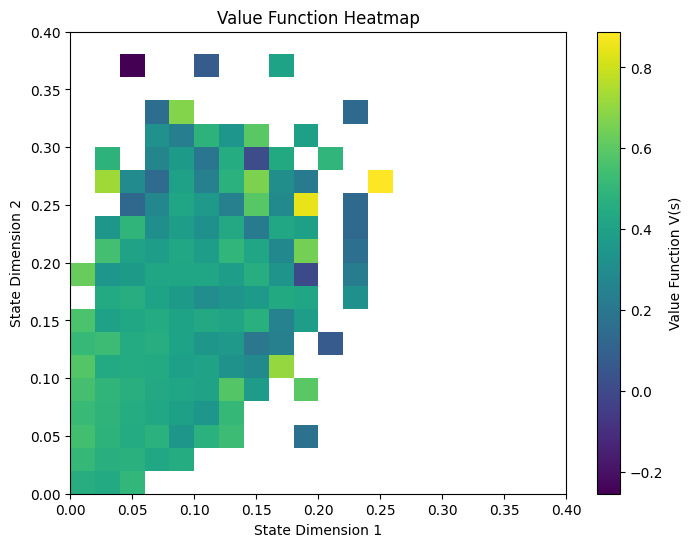

In [ ]:
state_range=(0, 0.4)
# Create a grid of state values
x = np.linspace(state_range[0], state_range[1], BINS)
y = np.linspace(state_range[0], state_range[1], BINS)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)
v_min=-1e7
v_max=1e7

# Compute V(s) for each (x, y) pair
for i in range(BINS):
    for j in range(BINS):
        s = np.array([X[i, j], Y[i, j]])  # Continuous state
        s_d = quantize(s, BINS)  # Discretized state
        value = V.get(s_d, np.nan)  # Use NaN for unseen statesom

        # Ignore extreme values
        if value < v_min or value > v_max:
            Z[i, j] = np.nan  # Mask extreme values
        else:
            Z[i, j] = value

# Plot heatmap, ignoring NaNs
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=[state_range[0], state_range[1], state_range[0], state_range[1]],
            origin="lower", cmap="viridis", aspect="auto", interpolation="nearest")
plt.colorbar(label="Value Function V(s)")
plt.xlabel("State Dimension 1")
plt.ylabel("State Dimension 2")
plt.title("Value Function Heatmap")
plt.show()

### Saving the Value function

In [ ]:
save_value_function(V, "V_initial_state.pkl")

Value function saved to V_initial_state.pkl


## Initial State MC Policy Eval with exploring starts (on action)

In [10]:

def generate_episode_exploring_starts():
    if verbose1=="on":
        print("Generating Episode...\n")
    c = C[np.random.choice(len(C))] # correct codeword
    snr = math.pow(10,snrdb_value/20)
    sigma = 1/math.sqrt(snr)
    y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape) # noisy codeword
    c_sent = np.array([1 if val<0 else 0 for val in y])
    dec = initialize_ldpc_decoder(H=H, snrdb=snrdb_value, c=c, num_iter=num_iter, cluster_size=cluster_size)
    
    # initial state is the same for all episodes
    state = get_state(dec, state_definition)

    # exploring_starts : tells if actions at the 1st state are chosen in randomized way
    # epsilon : probability with which the agent exploits, otherwise explores. None means equal probability exploration of each actions and no exploitation
    decoded_codeword, episode_list = dec.decode(y,verbose=verbose1,scheduling="mi",state_definition=state_definition, exploring_starts=True, epsilon=None )

    # for ep in episode_list:
    #     s,a,r = ep
    #     print("action = ",a,"\treward = ",r)
    if verbose2=="on":
        print(f"{len(episode_list)} length episode generated!")
        print(f"Error : {(np.sum(decoded_codeword+c)%2)}/{len(c)}")
        # print(f"c = {c}\nd = {decoded_codeword}")
    return episode_list


In [11]:
num_iter=150
cluster_size=15
snrdb_value = 1.5
scheduling = "mi"
state_definition="pseudo-difference"
STATE_DIM = math.ceil(H.shape[0]/cluster_size)
BINS = 100
verbose1 = "off"
verbose2 = "off"

V = initial_state_mc_policy_evaluation_q(
    generate_episode=generate_episode_exploring_starts,
    gamma=0.9,
    num_episodes=3000
    )

# print(V)

Iter num : 1	Episode Length : 150	 Time : 2.33 sec
Iter num : 2	Episode Length : 150	 Time : 2.73 sec
Iter num : 3	Episode Length : 150	 Time : 2.70 sec
Iter num : 4	Episode Length : 150	 Time : 2.49 sec
Iter num : 5	Episode Length : 150	 Time : 2.16 sec
Iter num : 6	Episode Length : 150	 Time : 2.20 sec
Iter num : 7	Episode Length : 150	 Time : 2.16 sec
Iter num : 8	Episode Length : 150	 Time : 2.26 sec
Iter num : 9	Episode Length : 3	 Time : 0.04 sec
Iter num : 10	Episode Length : 150	 Time : 2.08 sec
Iter num : 11	Episode Length : 150	 Time : 2.07 sec
Iter num : 12	Episode Length : 150	 Time : 2.12 sec
Iter num : 13	Episode Length : 150	 Time : 2.08 sec
Iter num : 14	Episode Length : 150	 Time : 2.15 sec
Iter num : 15	Episode Length : 150	 Time : 2.11 sec
Iter num : 16	Episode Length : 150	 Time : 2.08 sec
Iter num : 17	Episode Length : 150	 Time : 2.14 sec
Iter num : 18	Episode Length : 150	 Time : 2.09 sec
Iter num : 19	Episode Length : 150	 Time : 2.17 sec
Iter num : 20	Episode L

In [12]:
print(V)

defaultdict(<class 'float'>, {((52, 53), 1): 0.25118104241176775, ((54, 53), 0): 0.21280809066442788, ((51, 53), 1): 0.19094911221918995, ((55, 60), 1): 0.35310081519796255, ((54, 57), 1): 0.4239054234940909, ((54, 54), 0): 0.20039236833635252, ((53, 56), 1): 0.17637341038906584, ((52, 53), 0): 0.32053297050795937, ((52, 54), 1): 0.12726731722136098, ((50, 51), 1): 0.03889709681606237, ((53, 58), 1): 0.28660624875166263, ((53, 59), 0): 0.16795327686491965, ((51, 54), 1): 0.4221359093732396, ((54, 56), 1): 0.16745855002406448, ((53, 56), 0): 0.23002042808062984, ((53, 55), 1): 0.34781758262349305, ((52, 55), 1): 0.15868020725488174, ((51, 52), 0): 0.1483913462309836, ((54, 56), 0): 0.24933084568041386, ((52, 57), 0): 0.2282761771994696, ((52, 51), 0): 0.12153348645561393, ((54, 58), 0): 0.35410504606895027, ((53, 57), 1): 0.2170885613186978, ((52, 54), 0): 0.31696360038498295, ((53, 53), 1): 0.1379924876766467, ((52, 52), 1): 0.22869250905512215, ((50, 52), 1): 0.1881151375164257, ((53,

In [17]:
for k in range(100):
    s = np.random.uniform(0,0.2,STATE_DIM)
    s_d = quantize(s,BINS)
    val0,val1 = V.get((s_d,0),np.nan),V.get((s_d,1),np.nan)
    print(f"State : {s}\t d_s : {s_d}\t Value : ({val0},{val1})")

State : [0.12141238 0.18999147]	 d_s : (56, 59)	 Value : (0.38716689317023056,0.47287602117100686)
State : [0.09779213 0.07478178]	 d_s : (54, 53)	 Value : (0.21280809066442788,0.2501623161532)
State : [0.0955897  0.10478966]	 d_s : (54, 55)	 Value : (0.20274074958381788,0.21900343998925512)
State : [0.05198019 0.02289213]	 d_s : (52, 51)	 Value : (0.12153348645561393,0.1767172490444346)
State : [0.1039967  0.14996089]	 d_s : (55, 57)	 Value : (0.5125650870371955,0.22296074589630455)
State : [0.1120067 0.059703 ]	 d_s : (55, 52)	 Value : (0.18908009668268808,0.2630325855509787)
State : [0.06221794 0.13401481]	 d_s : (53, 56)	 Value : (0.23002042808062984,0.17637341038906584)
State : [0.12444378 0.18666103]	 d_s : (56, 59)	 Value : (0.38716689317023056,0.47287602117100686)
State : [0.14453069 0.18231176]	 d_s : (57, 59)	 Value : (0.43772599178662897,0.7872964068315571)
State : [0.17539633 0.15912745]	 d_s : (58, 57)	 Value : (0.4326399482287795,0.479274060815507)
State : [0.00639075 0.1

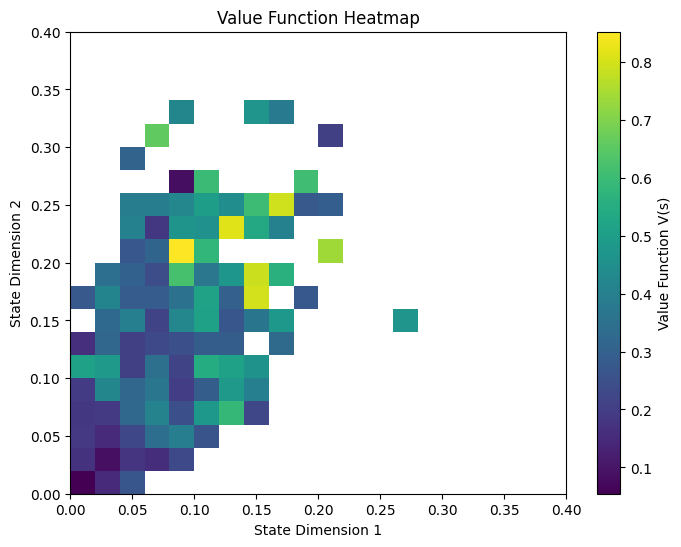

In [18]:
state_range=(0, 0.4)
# Create a grid of state values
x = np.linspace(state_range[0], state_range[1], BINS)
y = np.linspace(state_range[0], state_range[1], BINS)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)
v_min=-1e7
v_max=1e7

# Compute V(s) for each (x, y) pair
for i in range(BINS):
    for j in range(BINS):
        s = np.array([X[i, j], Y[i, j]])  # Continuous state
        s_d = quantize(s, BINS)  # Discretized state
        value0,value1 = V.get((s_d,0), np.nan),V.get((s_d,1), np.nan)  # Use NaN for unseen statesom
        Z[i,j] = max(value0,value1)
        action = np.argmax(np.array([value0,value1]))
        # # Ignore extreme values
        # if value < v_min or value > v_max:
        #     Z[i, j] = np.nan  # Mask extreme values
        # else:
        #     Z[i, j] = value

# Plot heatmap, ignoring NaNs
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=[state_range[0], state_range[1], state_range[0], state_range[1]],
            origin="lower", cmap="viridis", aspect="auto", interpolation="nearest")
plt.colorbar(label="Value Function V(s)")
plt.xlabel("State Dimension 1")
plt.ylabel("State Dimension 2")
plt.title("Value Function Heatmap")
plt.show()

In [19]:
save_value_function(V, "MI_policy_1.pkl")

Value function saved to MI_policy_1.pkl


<class 'dict'>
